In [1]:
!pip install dgl

In [2]:
!pip install geoopt
!pip install geomstats
!pip install dgl
!pip install torch

  Using cached geoopt-0.5.0-py3-none-any.whl.metadata (6.7 kB)
Using cached geoopt-0.5.0-py3-none-any.whl (90 kB)
  Using cached geomstats-2.7.0-py3-none-any.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.7 MB/s eta 0:00:00:00:01:01


In [3]:
import logging
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall

In [4]:
import random
import numpy as np
import torch
import dgl.data

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [5]:
import dgl
from dgl.data import AmazonCoBuyComputerDataset
# Load the Amazon Computers dataset
amazon_dataset = AmazonCoBuyComputerDataset()
# Select the first graph in the dataset
amazon_computer = amazon_dataset[0]

/root/.dgl/amazon_co_buy_computer.zip:   0%|          | 0.00/3.42M [00:00<?, ?B/s]

Extracting file to /root/.dgl/amazon_co_buy_computer_b5999b2e


In [6]:
Original_graph = amazon_computer   #DGL object
base_classes_graph = 5
num_support_base = 5
n_stream = 5
num_query_base = 5
start_seed_base = 100
num_episodes_base = 200
graph_feats_size = Original_graph.ndata['feat'].shape[1]
n_seed = 5
"""
meta_lr = 0.00001
"""


'\nmeta_lr = 0.00001\n'

In [7]:
import dgl
import numpy as np

def process_graph(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)
    remaining_classes -= set(p_classes)

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [8]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [9]:

# Example usage:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

# Sample a subgraph with 20 classes from the base graph
sampled_graph_base, _ = process_graph(
    Original_graph,
    num_classes_to_keep= base_classes_graph,
    random_seed = n_seed,
    remaining_classes=base_remaining_classes
)
print(f'Base graph classes: {get_unique_classes(sampled_graph_base)}')

Base graph classes: [2, 4, 5, 7, 9]


In [10]:
import random
import numpy as np
import torch
import dgl.data

class MetaDataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, num_walks, walk_length):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.task_data = []

    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task = {}
            support_set = []
            query_set = []

            unique_classes = np.unique(self.dataset.ndata['label'].numpy())
            class_group = np.random.choice(unique_classes, self.num_classes, replace=False)

            for c in class_group:
                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace=False)
                query_indices = np.random.choice(indices, size=self.num_query, replace=False)

                support_set.extend(support_indices)
                query_set.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set)
            support_random_walks_list.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set)
            query_random_walks_list.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set + [node for walk in query_random_walks for node in walk]))
            task['test'] = test_set

            train_set = list(set(support_set + [node for walk in support_random_walks for node in walk]))
            task['train'] = train_set
            task['query_set'] = query_set
            task['support_set'] = support_set
            task['seed'] = task_seed

            tasks.append(task)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list.append(edge_indices_test)
            edge_indices_train_list.append(edge_indices_train)

        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list

    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []


        for seed in self.random_seeds:
            tasks_data, edges_train, edges_test, support_walks, query_walks = self.create_task(seed, self.task_random_seeds)
            tasks.extend(tasks_data)
            edge_indices_train_list.extend(edges_train)
            edge_indices_test_list.extend(edges_test)
            support_random_walks_list.extend(support_walks)
            query_random_walks_list.extend(query_walks)



        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list


In [11]:
import torch
import dgl

def create_feature_label_extractor(graph, tasks):
    def feature_label_extractor(task_id, seed):
        task = tasks[task_id]

        train_set = task['train']
        test_set = task['test']
        support_set = task['support_set']  # Include support set
        query_set = task['query_set']  # Include query set

        # Extract features and labels for the entire graph
        all_features = graph.ndata['feat']
        all_labels = graph.ndata['label']

        # Extract features and labels for the train set
        train_features = all_features[train_set]
        train_labels = all_labels[train_set]

        # Extract features and labels for the test set
        test_features = all_features[test_set]
        test_labels = all_labels[test_set]

        # Extract features and labels for the support set
        support_features = all_features[support_set]
        support_labels = all_labels[support_set]

        # Extract features and labels for the query set
        query_features = all_features[query_set]
        query_labels = all_labels[query_set]

        # Calculate the degrees of nodes
        train_degrees = graph.in_degrees(train_set)
        test_degrees = graph.in_degrees(test_set)
        support_degrees = graph.in_degrees(support_set)
        query_degrees = graph.in_degrees(query_set)

        return (
            torch.tensor(train_features), torch.tensor(train_labels),
            torch.tensor(test_features), torch.tensor(test_labels),
            torch.tensor(support_features), torch.tensor(support_labels),
            torch.tensor(query_features), torch.tensor(query_labels),
            torch.tensor(train_degrees), torch.tensor(test_degrees),
            torch.tensor(support_degrees), torch.tensor(query_degrees)
        )

    return feature_label_extractor


In [12]:
import torch

def reindex_nodes(task_id, train_set_list, edge_indices_list, random_walks_list):
    # Extracting task-specific data
    train_set = train_set_list[task_id]
    src_train, dst_train = edge_indices_list[task_id]  # Assuming edge_indices_list is a list of tensors
    random_walks_train = random_walks_list[task_id]

    # Reindexing nodes in train_set
    node_mapping = {old_node: new_node for new_node, old_node in enumerate(train_set)}
    reindexed_train_set = [node_mapping[node] for node in train_set]

    # Reindexing nodes in edge_indices
    reindexed_edge_indices = torch.stack([
        torch.tensor([node_mapping.get(int(source), -1) for source in src_train], dtype=torch.long),
        torch.tensor([node_mapping.get(int(destination), -1) for destination in dst_train], dtype=torch.long)
    ], dim=0)

    # Filter out rows with missing nodes
    mask = (reindexed_edge_indices != -1).all(dim=0)
    reindexed_edge_indices = reindexed_edge_indices[:, mask]

    # Reindexing nodes in random_walks
    reindexed_random_walks = [
        [node_mapping.get(int(node), -1) for node in walk]
        for walk in random_walks_train
    ]

    # Filter out walks with missing nodes
    reindexed_random_walks = [walk for walk in reindexed_random_walks if -1 not in walk]

    # Create a dictionary for old to new node indices
    old_to_new_mapping = {old_node: new_node for old_node, new_node in node_mapping.items()}

    return reindexed_train_set, reindexed_edge_indices, reindexed_random_walks, old_to_new_mapping

In [13]:
def dict_for_custom_loss_function(reindexed_random_walks, old_to_new_mapping_train, graph):
    original_first_node_list = []
    remaining_nodes = []
    all_firsts = []

    for walks in reindexed_random_walks:
        reindexed_first_node = walks[0]
        all_firsts.append(reindexed_first_node)
        reindexed_remaining_nodes = walks[1:]
        #print(reindexed_remaining_nodes)

        # Find the corresponding original node index using the original-to-reindexed mapping
        original_first_node = next((old_node for old_node, new_node in old_to_new_mapping_train.items() if reindexed_first_node == new_node), None)
        original_first_node_list.append(original_first_node)
        remaining_nodes.append(reindexed_remaining_nodes)


    # Assuming original_labels is a dictionary with node indices as keys and labels as values
    labels_for_nodes = [graph.ndata['label'][node] for node in original_first_node_list if node is not None]

    return labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts

In [14]:
def create_label_dict(labels_for_nodes, remaining_nodes, all_firsts):
    final_list = []
    for i in range(len(labels_for_nodes)):
        final = [labels_for_nodes[i], remaining_nodes[i]]
        final_list.append(final)

    label_dict = {}
    for item in final_list:
        label = item[0].item()  # Convert tensor label to integer
        nodes_list = item[1]


        if label not in label_dict:
            label_dict[label] = nodes_list
        else:
            label_dict[label].extend(nodes_list)



    # Perform set operation to remove duplicates within each list
    for key in label_dict:
        label_dict[key] = list(set(label_dict[key]))

    return label_dict

In [15]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.5 MB/s eta 0:00:0000:01


In [16]:
import torch

def calculate_euclidean_prototype(features, degree_tensor, class_dict):
    # Initialize a dictionary to store prototypes for each class
    class_prototypes = {}

    for class_label, nodes in class_dict.items():
        # Extract features for the nodes in the current class
        class_features = features[nodes]

        # Extract degrees for the nodes in the current class
        class_degrees = degree_tensor[nodes]

        # Calculate the weighted sum of features
        weighted_sum = torch.sum(class_degrees.unsqueeze(1) * class_features, dim=0)

        # Calculate the sum of degrees
        sum_degrees = torch.sum(class_degrees)

        # Calculate the prototype (weighted average)
        prototype = weighted_sum / sum_degrees

        # Store the prototype in the dictionary
        class_prototypes[class_label] = prototype

    return class_prototypes

In [17]:
def get_unique_elements_in_order(input_list):
    unique_elements_set = set()
    unique_elements_list = []

    for element in input_list:
        if element not in unique_elements_set:
            unique_elements_set.add(element)
            unique_elements_list.append(element)

    return unique_elements_list

In [18]:
def add_elements_to_dictionary_list(reformulated_dict, unique_elements_result):
    for i, class_label in enumerate(reformulated_dict.keys()):
        # Get the row corresponding to the class label
        row_elements = unique_elements_result[i]

        # Add each element to the list in the dictionary
        for element in row_elements:
            reformulated_dict[class_label].append(element)

In [19]:
def create_C_dictionary(Reform_dict, proto_dict):
    # Ensure both dictionaries have the same keys
    common_keys = set(Reform_dict.keys()).intersection(proto_dict.keys())

    # Create a new dictionary with values from both dictionaries for common keys
    C_dict = {key: (Reform_dict[key], proto_dict[key]) for key in common_keys}

    # Access values individually
    Reform_values = {key: Reform_dict[key] for key in common_keys}
    Proto_values = {key: proto_dict[key] for key in common_keys}

    # Use values from proto_dict as keys in Reform_dict
    Reform_dict_with_proto_keys = {tuple((proto_dict[key]).numpy()): Reform_dict[key] for key in common_keys}

    return Reform_values, Proto_values, Reform_dict_with_proto_keys

In [20]:
import torch
import numpy as np
from torch_geometric.data import Data
import warnings
warnings.filterwarnings("ignore")

def base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds):
    train_indexes_before_reindexing_list = []
    test_indexes_before_reindexing_list = []
    task_datasets_euc = []
    context_dictionary_list = []
    train_set_list = []
    test_set_list = []
    euc_proto = []


    num_tasks = num_seeds
    
    metadata_generator = MetaDataGenerator(sampled_graph_base, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, 10, 5)
    tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list = metadata_generator.generate_tasks()

    for i, task in enumerate(tasks):
        #print(f"Task = {i} - Seed: {task_random_seeds[i]}")
        seed = task_random_seeds[i]
        extractor = create_feature_label_extractor(graph, tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed) 
        train_indexes_before_reindexing_list.append(task['train'])
        train_set_list.append(task['train'])
        test_set_list.append(task['test'])
        test_indexes_before_reindexing_list.append(task['test'])
        
        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_indexes_before_reindexing_list, edge_indices_train_list, support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_indexes_before_reindexing_list, edge_indices_test_list, query_random_walks_list)
        
        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))
        
        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)
        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)
        
        unique_elements_result = get_unique_elements_in_order(all_firsts)
        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        context_dictionary_list.append(result_label_dict)
        eucledian_prototype = calculate_euclidean_prototype(train_features, train_degrees, result_label_dict)
        euc_proto.append(eucledian_prototype)
        Reform_values, Proto_values, Reform_dict_with_proto_keys = create_C_dictionary(result_label_dict, eucledian_prototype)
        
    return context_dictionary_list, task_datasets_euc

graph = sampled_graph_base
num_classes = base_classes_graph
num_support = num_support_base
num_query = num_query_base
start_seed = start_seed_base
spacing = 50
num_seeds = num_episodes_base
task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
random_seeds = [42]

context_dictionary_list, task_datasets_euc = base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds)

In [21]:
!pip install torch_geometric

In [22]:
import torch

def Lintra_loss(embeddings, context_dictionary, target_radius):
    loss_intra = 0
    num_clusters = len(context_dictionary)

    # Calculate mean vectors for each cluster
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}

    # Calculate intra-cluster loss
    for j, cluster_elements in context_dictionary.items():
        mean_vector = mean_vectors[j]

        for i in cluster_elements:
            embedding_i = embeddings[i]
            norm_diff = torch.norm(embedding_i - mean_vector)
            loss_contrib = torch.clamp(norm_diff - target_radius, min=0)

            # Calculate the sum of all d_{ij} within the cluster
            sum_dij = torch.sum(torch.clamp(torch.norm(embeddings[cluster_elements] - mean_vector, dim=1) - target_radius, min=0))

            # Normalize dij by the sum of all dij within the cluster
            #normalized_dij = loss_contrib / sum_dij
            normalized_dij = loss_contrib 

            # Add the normalized contribution to the overall loss
            loss_intra += normalized_dij
            
    # Normalize the overall loss by the number of clusters
    loss_intra_normalized = loss_intra / num_clusters
    return loss_intra_normalized, mean_vectors


In [23]:
import torch

def Linter_loss(embeddings, context_dictionary):
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}

    loss_inter = 0
    num_clusters = len(context_dictionary)

    for j, cluster_j in context_dictionary.items():
        for p, cluster_p in context_dictionary.items():
            if p != j and j in mean_vectors and p in mean_vectors:  # Check if keys exist
                norm_diff = -torch.log(torch.norm(mean_vectors[j] - mean_vectors[p]) )
                loss_inter += norm_diff
    loss_inter_normalised = loss_inter / num_clusters
    return loss_inter_normalised, mean_vectors

In [24]:
import torch
import torch.nn.functional as F

def accuracy_cosine(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        similarities = {label: F.cosine_similarity(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the maximum cosine similarity
        closest_label_sim = max(similarities, key=similarities.get)

        # If the closest label by cosine similarity matches the true label, consider it correct
        if closest_label_sim == labels[i].item():
            correct += 1

    return correct / total

In [25]:
def accuracy_euclidean(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        distances = {label: torch.dist(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the minimum Euclidean distance
        closest_label_dist = min(distances, key=distances.get)

        # If the closest label by Euclidean distance matches the true label, consider it correct
        if closest_label_dist == labels[i].item():
            correct += 1

    return correct / total

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm


class GATmodel(nn.Module):
    '''
    input x shape is [node_num, node_feature]
    output out shape is [node_num, class_num]
    '''
    def __init__(self, in_feature, hidden_feature):
        super(GATmodel, self).__init__()
        self.in_feature = in_feature
        self.hidden_feature = hidden_feature
        self.build()
        print("GATConv init.")

    def build(self):
        self.gat_layer_1 = GATConv(in_channels=self.in_feature, out_channels=self.hidden_feature, heads=3, concat=False)
        self.gat_layer_2 = GATConv(in_channels=self.hidden_feature, out_channels=self.hidden_feature, heads=3, concat=False)
    
    def forward(self, x, edge_index):
        gout_1 = self.gat_layer_1(x, edge_index)
        gout_2 = F.dropout(F.relu(gout_1), p=0.2)
        gout_2 = self.gat_layer_2(gout_2, edge_index)
        return gout_2


def meta_train(meta_model, task_datasets, meta_lr, weight_decays, context_dictionary_list):
    optimizer = optim.Adam(meta_model.parameters(), lr=meta_lr, weight_decay=weight_decays)

    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

     

    # Inner loop (tasks)
    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data

        all_train_data.append(task_train_data)
        # Training phase
        meta_model.train()
        optimizer.zero_grad()

        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        train_label = task_train_data.y
        loss_intra, _ = Lintra_loss(train_output, context_dictionary_list[i], 0.01)
        loss_inter, mean_vectors = Linter_loss(train_output, context_dictionary_list[i])

        loss =   1 * loss_intra + 0.25 * loss_inter
        loss.backward()
        optimizer.step()
        

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)

        print(f'task = {i}, loss = {loss.item():.2f}, test acc = {test_acc:.2f}%')
        

    # Return  meta-model, task cluster means and task dictionary
    return  meta_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies

In [27]:
# Example usage:
in_channels = graph_feats_size
hidden_channels = 512
meta_lr = 0.000001
weight_decays = 5e-3  # List of weight decay values for each task


In [28]:
import time

# Record the start time
start_time = time.time()

# Instantiate the meta-model only once outside the loop
meta_model = GATmodel(in_channels, hidden_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)

# Train the meta-learning model with regularization
model, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = meta_train(meta_model, task_datasets_euc, meta_lr, weight_decays, context_dictionary_list)

# Find the episode number and corresponding accuracy with the highest accuracy
best_episode = max(task_dictionary, key=task_dictionary.get)
best_accuracy = task_dictionary[best_episode]

# Print the result
print(f"The best accuracy is {best_accuracy:.2f} at episode number {best_episode}.")

# Save the trained model
torch.save(model.state_dict(), 'meta_model.pth')

# Record the end time
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f'Total execution time: {execution_time} seconds')


GATConv init.
task = 0, loss = 56.04, test acc = 94.86%
task = 1, loss = 56.48, test acc = 94.66%
task = 2, loss = 52.40, test acc = 94.29%
task = 3, loss = 57.69, test acc = 94.71%
task = 4, loss = 53.15, test acc = 91.33%
task = 5, loss = 53.65, test acc = 94.15%
task = 6, loss = 56.13, test acc = 95.09%
task = 7, loss = 59.30, test acc = 87.23%
task = 8, loss = 52.96, test acc = 92.48%
task = 9, loss = 54.25, test acc = 90.55%
task = 10, loss = 53.90, test acc = 91.53%
task = 11, loss = 48.89, test acc = 92.02%
task = 12, loss = 58.08, test acc = 90.77%
task = 13, loss = 52.95, test acc = 93.42%
task = 14, loss = 57.40, test acc = 95.83%
task = 15, loss = 48.20, test acc = 94.23%
task = 16, loss = 55.61, test acc = 89.51%
task = 17, loss = 57.91, test acc = 93.04%
task = 18, loss = 57.17, test acc = 92.12%
task = 19, loss = 53.39, test acc = 95.47%
task = 20, loss = 55.30, test acc = 93.83%
task = 21, loss = 56.00, test acc = 93.11%
task = 22, loss = 57.50, test acc = 92.71%
task = 

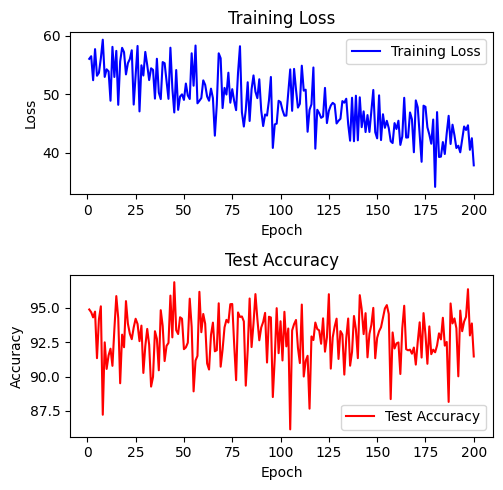

In [29]:
import matplotlib.pyplot as plt

def plot_performance(task_train_losses, task_test_accuracies):
    """
    Plots the training losses and test accuracies for a given task.

    Parameters:
    - task_train_losses (list): List of training losses for each epoch.
    - task_test_accuracies (list): List of test accuracies for each epoch.
    """
    epochs = range(1, len(task_train_losses) + 1)

    # Plotting training losses
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, task_train_losses, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting test accuracies
    plt.subplot(2, 1, 2)
    plt.plot(epochs, task_test_accuracies, 'r', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_performance(task_train_losses, task_test_accuracies)

In [30]:
# Print the result
print(f"The best accuracy is {best_accuracy:.2f}% at episode number: {best_episode}.")

The best accuracy is 96.84% at episode number: 44.


In [31]:
def consolidate_cluster_means(cluster_means, best_episode):
    if best_episode < 0 or best_episode >= len(cluster_means):
        raise ValueError("best_episode index is out of range")

    # Access the dictionary corresponding to the best episode
    best_episode_dict = cluster_means[best_episode][0]

    return best_episode_dict

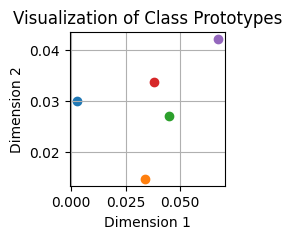

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cluster_means_tsne(coordinates, figsize=(2, 2)):
    # Convert coordinates to numpy array
    coordinates_array = np.array([coord.detach().numpy() if isinstance(coord, torch.Tensor) else coord for coord in coordinates.values()])

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)  # Specify the figure size
    for i, (label, coord) in enumerate(coordinates.items()):
        if isinstance(coord, torch.Tensor):
            coord = coord.detach().numpy()
        ax.scatter(coord[0], coord[1], label=f'Class {label}')
        #ax.annotate(f'{label}', (coord[0], coord[1]), textcoords="offset points", xytext=(0,5), ha='center')

    # Add labels and legend
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title('Visualization of Class Prototypes')

    # Add grid lines
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage:
# Assuming coordinates is a dictionary where keys are class labels and values are tensors
plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode), figsize=(2, 2))


In [33]:
# break

### Finetuning

In [34]:
meta_model = GATmodel(in_channels, hidden_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)

GATConv init.


In [35]:
# Load the saved model
loaded_model = GATmodel(in_channels, hidden_channels)
loaded_model.load_state_dict(torch.load('/kaggle/working/meta_model.pth'))
loaded_model = loaded_model.to(device)
print(loaded_model)

GATConv init.
GATmodel(
  (gat_layer_1): GATConv(767, 512, heads=3)
  (gat_layer_2): GATConv(512, 512, heads=3)
)


In [36]:
import dgl
import numpy as np

def process_incremental_graphs(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)


    #print(f"Sampled Classes: {p_classes}")

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [37]:
import random
import numpy as np
import torch
import dgl.data
from collections import OrderedDict

class FineTune_DataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, num_walks, walk_length, stream_seed):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.base_classes = base_classes
        self.novel_classes_list = novel_classes_list
        self.stream_seed = stream_seed
        self.task_data = []


    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds, base_classes, novel_classes_list):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task_base_unique_classes = {}
            task_last_k_classes = {}
            support_set_last_k_classes = []
            support_set_base_unique_classes = []
            query_set_last_k_classes = []
            query_set_base_unique_classes = []




            for c in base_classes:

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= False)
                query_indices = np.random.choice(indices, size=self.num_query, replace= False)

                support_set_base_unique_classes.extend(support_indices)
                query_set_base_unique_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_base_unique_classes)
            support_random_walks_list_base_unique_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_base_unique_classes)
            query_random_walks_list_base_unique_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_base_unique_classes + [node for walk in query_random_walks for node in walk]))
            task_base_unique_classes['test'] = test_set

            train_set = list(set(support_set_base_unique_classes + [node for walk in support_random_walks for node in walk]))
            task_base_unique_classes['train'] = train_set
            task_base_unique_classes['query_set'] = query_set_base_unique_classes
            task_base_unique_classes['support_set'] = support_set_base_unique_classes
            task_base_unique_classes['seed'] = task_seed

            tasks_base_unique_classes.append(task_base_unique_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_base_unique_classes.append(edge_indices_test)
            edge_indices_train_list_base_unique_classes.append(edge_indices_train)



            for c in novel_classes_list:
                np.random.seed(self.stream_seed)

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= True)
                query_indices = np.random.choice(indices, size=self.num_query, replace= True)

                support_set_last_k_classes.extend(support_indices)
                query_set_last_k_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_last_k_classes)
            support_random_walks_list_last_k_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_last_k_classes)
            query_random_walks_list_last_k_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_last_k_classes + [node for walk in query_random_walks for node in walk]))
            task_last_k_classes['test'] = test_set

            train_set = list(set(support_set_last_k_classes + [node for walk in support_random_walks for node in walk]))
            task_last_k_classes['train'] = train_set
            task_last_k_classes['query_set'] = query_set_last_k_classes
            task_last_k_classes['support_set'] = support_set_last_k_classes
            task_last_k_classes['seed'] = task_seed

            tasks_last_k_classes.append(task_last_k_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_last_k_classes.append(edge_indices_test)
            edge_indices_train_list_last_k_classes.append(edge_indices_train)

        return tasks_last_k_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_last_k_classes, query_random_walks_list_last_k_classes, tasks_base_unique_classes, edge_indices_train_list_base_unique_classes, edge_indices_test_list_base_unique_classes, support_random_walks_list_base_unique_classes, query_random_walks_list_base_unique_classes



    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []


        for seed in self.random_seeds:
            tasks_data_last_k_classes, edges_train_last_k_classes, edges_test_last_k_classes, support_walks_last_k_classes, query_walks_last_k_classes, tasks_data_base_unique_classes, edges_train_base_unique_classes, edges_test_base_unique_classes, support_walks_base_unique_classes, query_walks_base_unique_classes = self.create_task(seed, self.task_random_seeds, self.base_classes, self.novel_classes_list)
            tasks_base_unique_classes.extend(tasks_data_base_unique_classes)
            tasks_last_k_classes.extend(tasks_data_last_k_classes)
            edge_indices_train_list_base_unique_classes.extend(edges_train_base_unique_classes)
            edge_indices_train_list_last_k_classes.extend(edges_train_last_k_classes)
            edge_indices_test_list_base_unique_classes.extend(edges_test_base_unique_classes)
            edge_indices_test_list_last_k_classes.extend(edges_test_last_k_classes)
            support_random_walks_list_base_unique_classes.extend(support_walks_base_unique_classes)
            support_random_walks_list_last_k_classes.extend(support_walks_last_k_classes)
            query_random_walks_list_base_unique_classes.extend(query_walks_base_unique_classes)
            query_random_walks_list_last_k_classes.extend(query_walks_last_k_classes)


        return tasks_base_unique_classes, tasks_last_k_classes , edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes


In [38]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_context_and_datasets(graph, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds):
    # Your existing code for generating random seeds
    task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
    random_seeds = [42]
    num_tasks = num_seeds

    # Your existing code for generating tasks and extracting features
    metadata_generator = FineTune_DataGenerator(graph, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, 10, 5,  stream_seed)
    tasks_base_unique_classes, tasks_last_k_classes, edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes = metadata_generator.generate_tasks()

    # Your existing code for combining tasks
    combined_query_random_walks_list = [
        query_base + query_last_k
        for query_base, query_last_k in zip(query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes)
    ]

    # Your existing code for combining edge indices
    combined_edge_indices_train_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes)
    ]

    combined_edge_indices_test_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes)
    ]

    # Your existing code for combining support random walks
    combined_support_random_walks_list = [
        support_base + support_last_k
        for support_base, support_last_k in zip(support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes)
    ]

    combined_tasks = []
    for base_task, last_k_task in zip(tasks_base_unique_classes, tasks_last_k_classes):
        combined_task = {
            'test': base_task['test'] + last_k_task['test'],
            'train': base_task['train'] + last_k_task['train'],
            'query_set': base_task['query_set'] + last_k_task['query_set'],
            'support_set': base_task['support_set'] + last_k_task['support_set'],
            'seed': base_task['seed'],  # You may want to choose which seed to use
        }
        combined_tasks.append(combined_task)

    train_set_list = []
    test_set_list = []
    context_dictionary_list = []
    task_datasets_euc = []

    for i, task in enumerate(combined_tasks):
        #print(f"Episodes: {i} - Seed: {task['seed']}, streaming seed = {stream_seed}")
        seed = tasks_last_k_classes[i]['seed']
        extractor = create_feature_label_extractor(graph, combined_tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed)

        train_set_list.append(task['train'])
        test_set_list.append(task['test'])

        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_set_list, combined_edge_indices_train_list, combined_support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_set_list, combined_edge_indices_test_list, combined_query_random_walks_list)

        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))

        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)

        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)

        unique_elements_result = get_unique_elements_in_order(all_firsts)

        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        # Print the reformulated dictionary after adding elements
        context_dictionary_list.append(result_label_dict)

    return context_dictionary_list, task_datasets_euc


In [39]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [40]:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

sampled_graph_base, _ = process_incremental_graphs(
    Original_graph,
    num_classes_to_keep= 6,
    random_seed= n_seed,
    remaining_classes=base_remaining_classes
)
get_unique_classes(sampled_graph_base)

[1, 2, 4, 5, 7, 9]

knowledge distillation

In [41]:
import torch

def KDloss(teacher_train_output, train_output, novel_classes, train_label):
    # Convert novel_classes to a tensor for comparison
    novel_classes_tensor = torch.tensor(novel_classes)

    # Find indices of rows in train_label corresponding to novel_classes
    novel_indices = torch.where(torch.isin(train_label, novel_classes_tensor))[0]

    # Create a boolean mask for filtering
    mask = torch.ones(len(train_label), dtype=torch.bool)
    mask[novel_indices] = False

    # Filter out the corresponding rows from teacher_train_output and train_output
    teacher_train_output_filtered = teacher_train_output[mask]
    train_output_filtered = train_output[mask]


    # Node alignment loss
    squared_distance = torch.sum((torch.exp(teacher_train_output_filtered) - torch.exp(train_output_filtered)) ** 1, dim=1)
    # Average over samples
    N = teacher_train_output_filtered.size(0)
    node_loss = torch.mean(squared_distance) / N

   

    return node_loss


In [42]:
def fine_tune(teacher_model, novel_classes, meta_model, task_datasets, ft_lr, weight_decays, context_dictionary_list):
    optimizer = optim.Adam(meta_model.parameters(), lr=ft_lr, weight_decay=weight_decays)

    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

     

    # Inner loop (tasks)
    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data

        all_train_data.append(task_train_data)
        
        # teacher model will be in evaluation mode
        teacher_model.eval()
        
        
        teacher_train_output = teacher_model(task_train_data.x, task_train_data.edge_index)
        # Training phase
        meta_model.train()
        optimizer.zero_grad()

        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        train_label = task_train_data.y
        loss_intra, _ = Lintra_loss(train_output, context_dictionary_list[i], 0.01)
        loss_inter, mean_vectors = Linter_loss(train_output, context_dictionary_list[i])
        
        
        
        # Calculate the knowledge distillation loss
        node_loss = KDloss(teacher_train_output, train_output, novel_classes, train_label)
        


        loss =   1 * loss_intra + 1 * loss_inter + node_loss
        loss.backward()
        optimizer.step()
        

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)

        print(f'task = {i}, loss = {loss.item():.2f}, test acc = {test_acc:.2f}%')


    # Return  meta-model, task cluster means and task dictionary
    return  meta_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies

Number of Classes (Base) = 5, Base classes are: [2, 4, 5, 7, 9]
========================== Streaming session: 1 ==========================
Number of Classes (Base + Novel) = 6
Novel classes are: [1]
Base Classes: [2, 4, 5, 7, 9]
Total Novel Classes List: [1]
task = 0, loss = 62.41, test acc = 88.15%
task = 1, loss = 60.97, test acc = 84.65%
task = 2, loss = 55.80, test acc = 86.32%
task = 3, loss = 61.03, test acc = 77.65%
task = 4, loss = 63.93, test acc = 81.67%
task = 5, loss = 63.85, test acc = 82.84%
task = 6, loss = 58.42, test acc = 83.91%
task = 7, loss = 56.71, test acc = 85.25%
task = 8, loss = 59.08, test acc = 85.08%
task = 9, loss = 59.27, test acc = 86.87%
task = 10, loss = 58.98, test acc = 87.46%
task = 11, loss = 58.13, test acc = 84.88%
task = 12, loss = 64.04, test acc = 86.65%
task = 13, loss = 67.15, test acc = 84.09%
task = 14, loss = 64.11, test acc = 84.61%
task = 15, loss = 57.06, test acc = 89.25%
task = 16, loss = 65.96, test acc = 86.41%
task = 17, loss = 61

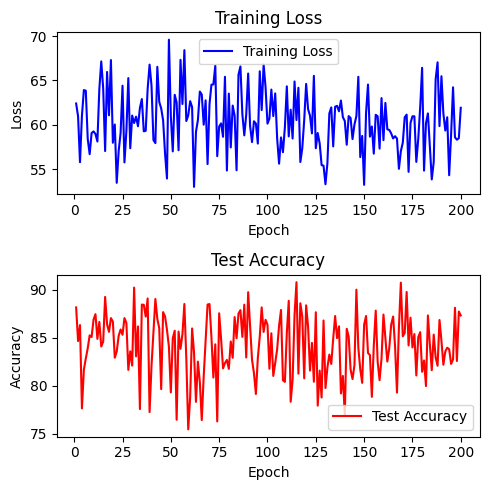

The best accuracy is 90.78% at episode number 114.


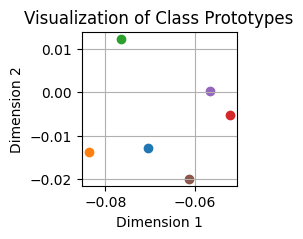

Plot saved as: streaming_plot_1.png
========================== Streaming session: 2 ==========================
Number of Classes (Base + Novel) = 7
Novel classes are: [0]
Base Classes: [2, 4, 5, 7, 9]
Total Novel Classes List: [1, 0]
task = 0, loss = 63.87, test acc = 80.61%
task = 1, loss = 63.71, test acc = 81.14%
task = 2, loss = 62.86, test acc = 85.12%
task = 3, loss = 73.24, test acc = 84.69%
task = 4, loss = 67.43, test acc = 83.46%
task = 5, loss = 59.24, test acc = 79.49%
task = 6, loss = 63.28, test acc = 84.18%
task = 7, loss = 60.01, test acc = 87.65%
task = 8, loss = 61.41, test acc = 82.32%
task = 9, loss = 65.31, test acc = 77.99%
task = 10, loss = 64.16, test acc = 80.95%
task = 11, loss = 69.85, test acc = 85.73%
task = 12, loss = 61.61, test acc = 78.23%
task = 13, loss = 66.96, test acc = 84.55%
task = 14, loss = 64.49, test acc = 83.57%
task = 15, loss = 64.98, test acc = 83.57%
task = 16, loss = 65.24, test acc = 83.22%
task = 17, loss = 62.77, test acc = 83.70%
ta

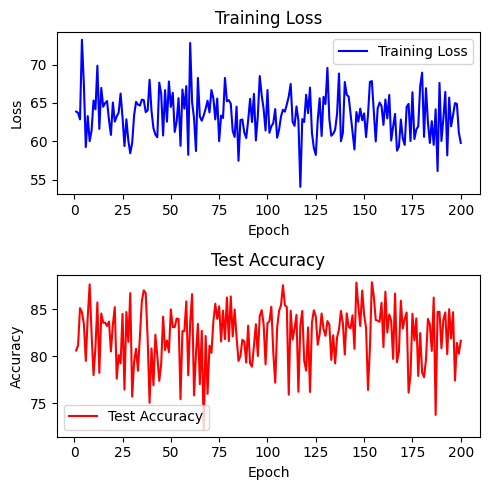

The best accuracy is 87.88% at episode number 153.


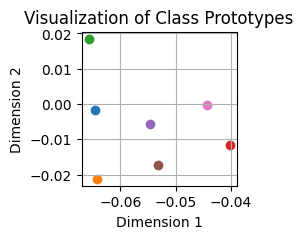

Plot saved as: streaming_plot_2.png
========================== Streaming session: 3 ==========================
Number of Classes (Base + Novel) = 8
Novel classes are: [8]
Base Classes: [2, 4, 5, 7, 9]
Total Novel Classes List: [1, 0, 8]
task = 0, loss = 67.91, test acc = 72.94%
task = 1, loss = 66.08, test acc = 76.07%
task = 2, loss = 64.95, test acc = 78.74%
task = 3, loss = 65.70, test acc = 80.38%
task = 4, loss = 62.43, test acc = 71.47%
task = 5, loss = 66.85, test acc = 76.90%
task = 6, loss = 67.76, test acc = 68.62%
task = 7, loss = 67.32, test acc = 76.01%
task = 8, loss = 62.46, test acc = 76.40%
task = 9, loss = 60.97, test acc = 79.03%
task = 10, loss = 65.43, test acc = 79.44%
task = 11, loss = 67.20, test acc = 77.37%
task = 12, loss = 64.53, test acc = 79.66%
task = 13, loss = 66.55, test acc = 79.00%
task = 14, loss = 65.38, test acc = 72.80%
task = 15, loss = 64.52, test acc = 78.89%
task = 16, loss = 63.77, test acc = 73.66%
task = 17, loss = 64.23, test acc = 79.13%

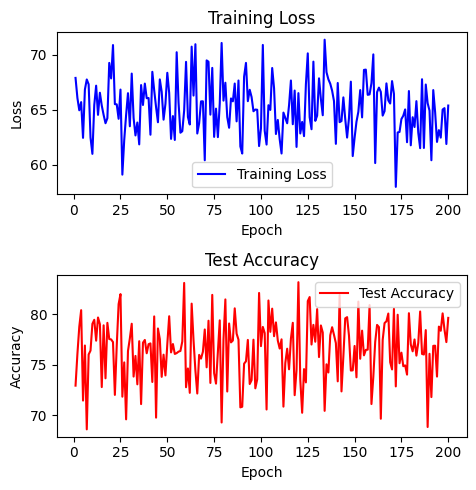

The best accuracy is 83.14% at episode number 119.


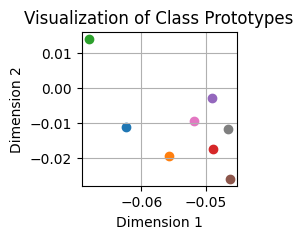

Plot saved as: streaming_plot_3.png
========================== Streaming session: 4 ==========================
Number of Classes (Base + Novel) = 9
Novel classes are: [6]
Base Classes: [2, 4, 5, 7, 9]
Total Novel Classes List: [1, 0, 8, 6]
task = 0, loss = 66.94, test acc = 65.98%
task = 1, loss = 69.34, test acc = 71.77%
task = 2, loss = 67.55, test acc = 68.76%
task = 3, loss = 65.01, test acc = 70.44%
task = 4, loss = 63.07, test acc = 69.39%
task = 5, loss = 70.07, test acc = 68.57%
task = 6, loss = 65.98, test acc = 69.64%
task = 7, loss = 62.71, test acc = 62.70%
task = 8, loss = 66.46, test acc = 69.09%
task = 9, loss = 68.03, test acc = 69.65%
task = 10, loss = 67.02, test acc = 70.33%
task = 11, loss = 64.92, test acc = 68.71%
task = 12, loss = 64.62, test acc = 67.84%
task = 13, loss = 65.48, test acc = 67.60%
task = 14, loss = 64.15, test acc = 67.21%
task = 15, loss = 68.61, test acc = 71.67%
task = 16, loss = 62.68, test acc = 63.09%
task = 17, loss = 68.79, test acc = 66.

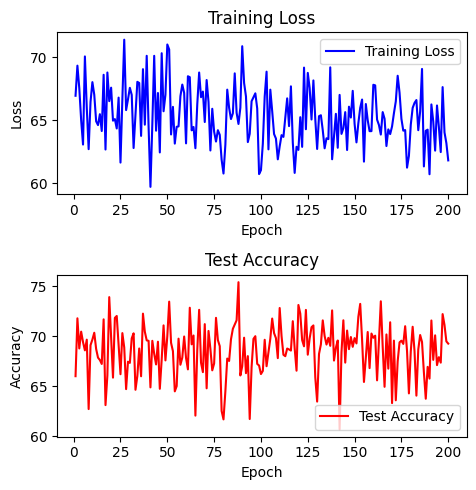

The best accuracy is 75.38% at episode number 87.


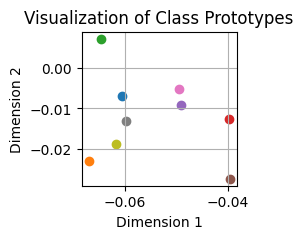

Plot saved as: streaming_plot_4.png
========================== Streaming session: 5 ==========================
Number of Classes (Base + Novel) = 10
Novel classes are: [3]
Base Classes: [2, 4, 5, 7, 9]
Total Novel Classes List: [1, 0, 8, 6, 3]
task = 0, loss = 63.74, test acc = 66.19%
task = 1, loss = 64.24, test acc = 69.92%
task = 2, loss = 66.86, test acc = 62.07%
task = 3, loss = 63.51, test acc = 66.60%
task = 4, loss = 66.74, test acc = 67.52%
task = 5, loss = 62.63, test acc = 69.20%
task = 6, loss = 64.15, test acc = 67.23%
task = 7, loss = 64.67, test acc = 70.70%
task = 8, loss = 63.26, test acc = 63.93%
task = 9, loss = 65.04, test acc = 70.42%
task = 10, loss = 63.74, test acc = 66.06%
task = 11, loss = 65.44, test acc = 71.86%
task = 12, loss = 66.32, test acc = 69.63%
task = 13, loss = 65.98, test acc = 69.46%
task = 14, loss = 66.57, test acc = 71.77%
task = 15, loss = 63.74, test acc = 67.11%
task = 16, loss = 63.05, test acc = 71.46%
task = 17, loss = 64.46, test acc =

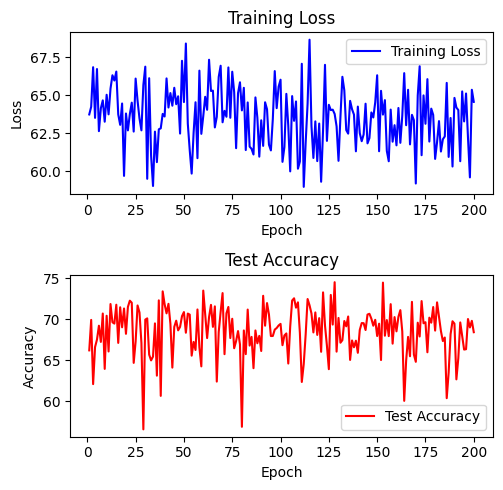

The best accuracy is 74.52% at episode number 127.


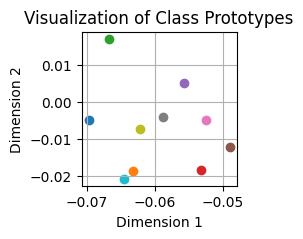

Plot saved as: streaming_plot_5.png
Total execution time: 4096.58379650116 seconds.


In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

streaming_seeds = [52, 46, 11, 24, 52, 70, 66, 41, 162, 1110]   #for novel
starting_seeds = [425, 310, 20,180, 535, 110, 195, 233, 541, 945]
previous_classes = set()  # Initialize an empty set outside the loop
base_classes_list = []    # Initialize an empty list for base classes
novel_classes_list = []   # Initialize an empty list for novel classes
p = 0

start_time = time.time()  # Record start time

for i in range(5, 11, 1):
    sampled_graph_base, _ = process_incremental_graphs(
        Original_graph,
        num_classes_to_keep=i,
        random_seed=n_seed,
        remaining_classes=base_remaining_classes
    )

    all_classes = get_unique_classes(sampled_graph_base)

    if i == 5:
        base_classes = list(set(all_classes))
        base_classes_list.extend(all_classes)  # Append base classes to the list
        print(f'Number of Classes (Base) = {i}, Base classes are: {base_classes}')
    else:
        print(f"========================== Streaming session: {p+1} ==========================")
        print(f'Number of Classes (Base + Novel) = {i}')
        novel_classes = list(set(all_classes) - previous_classes)
        novel_classes_list.extend(novel_classes)  # Append novel classes to the list
        print(f'Novel classes are: {novel_classes}')
        stream_seed = streaming_seeds[p]
        start_seed = starting_seeds[p]
        p += 1

        # Print the total novel classes list at each step only for i > 20
        print(f'Base Classes: {base_classes}')
        print(f'Total Novel Classes List: {novel_classes_list}')

        num_classes = i
        num_support = n_stream
        num_query = 5
        spacing = 50
        num_seeds = 200  #number of episodes in each stream
        ft_lr = 0.0000001

        context_dictionary_list, task_datasets_eucledian = create_context_and_datasets(sampled_graph_base, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds)
        
        # Train the meta-learning model with regularization
        teacher_model = loaded_model
        current_model, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = fine_tune(teacher_model, novel_classes, meta_model, task_datasets_eucledian, ft_lr, weight_decays, context_dictionary_list)
        loaded_model = current_model
        # Find the episode number and corresponding accuracy with the highest accuracy
        best_episode = max(task_dictionary, key=task_dictionary.get)
        best_accuracy = task_dictionary[best_episode]
        
        # Save the model after each streaming session
        model_name = f'streaming_model_{p}.pt'
        torch.save(model.state_dict(), model_name)
        print(f'Model saved as: {model_name}')
        
        # Print the result
        plot_performance(task_train_losses, task_test_accuracies)
        print(f"The best accuracy is {best_accuracy:.2f}% at episode number {best_episode}.")
        plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode))
        # Save the plot as an image
        plot_name = f'streaming_plot_{p}.png'
        plt.savefig(plot_name)
        print(f'Plot saved as: {plot_name}')
        plt.close()  # Close the current plot to avoid overlapping with the next iteration
        
    previous_classes = set(all_classes)

end_time = time.time()  # Record end time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time} seconds.")
